In [178]:
import pandas as pd
import geopandas as gpd
import xarray as xr
import os
from pyproj import Transformer
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import box, Polygon
from multiprocessing import Pool, cpu_count

In [179]:
cams2017 = xr.open_dataset("cams/PM10_daymean_2018.nc")
print(cams2017)

<xarray.Dataset> Size: 8MB
Dimensions:    (lon: 40, lat: 66, time: 365, bnds: 2)
Coordinates:
  * lon        (lon) float64 320B -10.0 -9.9 -9.8 -9.7 ... -6.4 -6.3 -6.2 -6.1
  * lat        (lat) float64 528B 36.5 36.6 36.7 36.8 ... 42.7 42.8 42.9 43.0
  * time       (time) datetime64[ns] 3kB 2018-01-01T11:30:00 ... 2018-12-31T1...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 6kB ...
    pm10       (time, lat, lon) float64 8MB ...
Attributes:
    CDI:          Climate Data Interface version ?? (http://mpimet.mpg.de/cdi)
    history:      Fri Apr 11 15:45:44 2025: cdo daymean PM10_2018.nc PM10_day...
    Conventions:  CF-1.7
    Title:        CAMS European air quality validated reanalysis
    Provider:     COPERNICUS European air quality service
    Production:   COPERNICUS Atmosphere Monitoring Service
    CDO:          Climate Data Operators version 1.7.0 (http://mpimet.mpg.de/...


In [180]:
print(cams2017.data_vars)
print("---------------------------------------\n")
print(cams2017.coords)
print("---------------------------------------\n")
print(cams2017["pm10"])
print("---------------------------------------")

Data variables:
    time_bnds  (time, bnds) datetime64[ns] 6kB ...
    pm10       (time, lat, lon) float64 8MB ...
---------------------------------------

Coordinates:
  * lon      (lon) float64 320B -10.0 -9.9 -9.8 -9.7 ... -6.4 -6.3 -6.2 -6.1
  * lat      (lat) float64 528B 36.5 36.6 36.7 36.8 36.9 ... 42.7 42.8 42.9 43.0
  * time     (time) datetime64[ns] 3kB 2018-01-01T11:30:00 ... 2018-12-31T11:...
---------------------------------------

<xarray.DataArray 'pm10' (time: 365, lat: 66, lon: 40)> Size: 8MB
[963600 values with dtype=float64]
Coordinates:
  * lon      (lon) float64 320B -10.0 -9.9 -9.8 -9.7 ... -6.4 -6.3 -6.2 -6.1
  * lat      (lat) float64 528B 36.5 36.6 36.7 36.8 36.9 ... 42.7 42.8 42.9 43.0
  * time     (time) datetime64[ns] 3kB 2018-01-01T11:30:00 ... 2018-12-31T11:...
Attributes:
    standard_name:                 mass_concentration_of_pm10_ambient_aerosol...
    long_name:                     mass concentration of particulate matter w...
    units:              

In [181]:
pm10_day = cams2017["pm10"].sel(time="2018-06-20").squeeze()

In [182]:
lats = pm10_day['lat'].values
lons = pm10_day['lon'].values
pm10_vals = pm10_day.values

In [183]:
print(pm10_day.shape)

(66, 40)


In [184]:
lat_step = lats[1] - lats[0]
lon_step = lons[1] - lons[0]

records = []
for i, lat in enumerate(lats):
    for j, lon in enumerate(lons):
        value = pm10_vals[i, j]
        if pd.isna(value):  # skip missing data
            continue
        cell = box(
            lon - lon_step / 2,
            lat - lat_step / 2,
            lon + lon_step / 2,
            lat + lat_step / 2
        )
        records.append({
            "geometry": cell,
            "pm10": value,
            "lat": lat,
            "lon": lon
        })

gdf = gpd.GeoDataFrame(records, crs="EPSG:4326")

In [185]:
print(gdf.head())

                                            geometry       pm10   lat   lon
0  POLYGON ((-9.95 36.45, -9.95 36.55, -10.05 36....  21.447265  36.5 -10.0
1  POLYGON ((-9.85 36.45, -9.85 36.55, -9.95 36.5...  21.246418  36.5  -9.9
2  POLYGON ((-9.75 36.45, -9.75 36.55, -9.85 36.5...  21.712890  36.5  -9.8
3  POLYGON ((-9.65 36.45, -9.65 36.55, -9.75 36.5...  23.103515  36.5  -9.7
4  POLYGON ((-9.55 36.45, -9.55 36.55, -9.65 36.5...  24.775390  36.5  -9.6


                                            geometry       pm10   lat   lon
0  POLYGON ((-162890.019 -355684.449, -162680.605...  21.447265  36.5 -10.0
1  POLYGON ((-153923.887 -355848.775, -153726.01 ...  21.246418  36.5  -9.9
2  POLYGON ((-144957.894 -356003.793, -144771.551...  21.712890  36.5  -9.8
3  POLYGON ((-135992.032 -356149.504, -135817.222...  23.103515  36.5  -9.7
4  POLYGON ((-127026.293 -356285.91, -126863.014 ...  24.775390  36.5  -9.6


<Axes: >

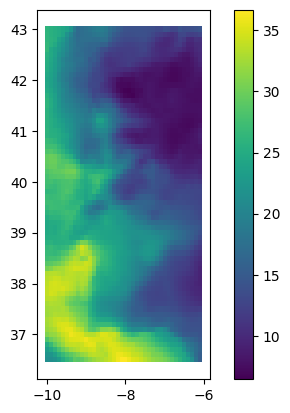

In [186]:
gdf_3763 = gdf.to_crs(3763)
print(gdf_3763.head())
gdf.plot(column="pm10", legend=True)

In [187]:
df = gpd.read_file("cos/COS2018_v1/COS2018_v1.shp")
print(df.shape)

(653840, 6)


In [188]:
def classify_land_use(code):
    if code.startswith('1.1') or code.startswith('1.2.1') or code.startswith('1.2.2') or \
       code.startswith('1.3') or code.startswith('1.5'):
        return 'Urbanizado'
    elif code.startswith('1.4'):
        return 'Transporte'
    else:
        return 'Outros'

df['Uso_solo_simplificado'] = df['COS2018_n4'].apply(classify_land_use)


In [189]:
_ = df.sindex
_ = gdf.sindex

In [190]:
def assign_landuse(
    cells_gdf,
    landuse_gdf,
    transporte_threshold=3,
    urbanizado_threshold=3.7,
    noclass_threshold=40.0,
    noclass_label="Sem classificação"
):
    """
    Assign dominant land use class to each cell with override rules.
    - If Transporte ≥ transporte_threshold%, override
    - If Urbanizado ≥ urbanizado_threshold%, override
    - If more than noclass_threshold% of the cell has no land use, return 'Sem classificação'
    """
    # Ensure valid geometries and matching CRS
    cells_gdf = cells_gdf.to_crs(landuse_gdf.crs)
    cells_gdf = cells_gdf[cells_gdf.is_valid]
    landuse_gdf = landuse_gdf[landuse_gdf.is_valid]

    # Add unique ID to each cell
    cells_gdf = cells_gdf.copy()
    cells_gdf["cell_id"] = cells_gdf.index

    # Intersect cells with land use polygons
    intersected = gpd.overlay(
        cells_gdf[["geometry", "cell_id"]],
        landuse_gdf[["geometry", "Uso_solo_simplificado"]],
        how="intersection"
    )

    # Area calculation
    intersected["area"] = intersected.geometry.area

    # Total area per cell
    total_area = (
        intersected.groupby("cell_id")["area"]
        .sum()
        .rename("intersected_area")
        .reset_index()
    )

    # Add total cell area
    cells_gdf["cell_area"] = cells_gdf.geometry.area
    total_area = total_area.merge(cells_gdf[["cell_id", "cell_area"]], on="cell_id")
    total_area["no_class_pct"] = 100 * (1 - total_area["intersected_area"] / total_area["cell_area"])

    # Compute % by class
    intersected = intersected.merge(total_area[["cell_id", "cell_area"]], on="cell_id")
    intersected["percentage"] = 100 * (intersected["area"] / intersected["cell_area"])

    # Get % for Transporte and Urbanizado
    transporte_pct = intersected[intersected["Uso_solo_simplificado"] == "Transporte"] \
        .groupby("cell_id")["percentage"].sum().rename("transporte_pct")
    urbanizado_pct = intersected[intersected["Uso_solo_simplificado"] == "Urbanizado"] \
        .groupby("cell_id")["percentage"].sum().rename("urbanizado_pct")

    # Dominant class by area
    dominant = (
        intersected
        .sort_values("area", ascending=False)
        .drop_duplicates("cell_id")
        .loc[:, ["cell_id", "Uso_solo_simplificado"]]
        .rename(columns={"Uso_solo_simplificado": "dominant_class"})
    )

    # Merge everything
    result = cells_gdf.copy()
    result = result.merge(dominant, on="cell_id", how="left")
    result = result.merge(transporte_pct, on="cell_id", how="left")
    result = result.merge(urbanizado_pct, on="cell_id", how="left")
    result = result.merge(total_area[["cell_id", "no_class_pct"]], on="cell_id", how="left")

    # Fill missing with 0 for override logic
    result["transporte_pct"] = result["transporte_pct"].fillna(0)
    result["urbanizado_pct"] = result["urbanizado_pct"].fillna(0)
    result["no_class_pct"] = result["no_class_pct"].fillna(100)  # full missing = 100%

    # Apply final rule
    def resolve_class(row):
        if row["no_class_pct"] >= noclass_threshold:
            return noclass_label
        elif row["transporte_pct"] >= transporte_threshold:
            return "Transporte"
        elif row["urbanizado_pct"] >= urbanizado_threshold:
            return "Urbanizado"
        else:
            return row["dominant_class"]

    result["final_class"] = result.apply(resolve_class, axis=1)

    return result

In [191]:
gdf_landuse = assign_landuse(gdf_3763, df)

In [192]:
gdf_landuse.to_file("pm10_grid_with_landuse.gpkg", driver="GPKG")

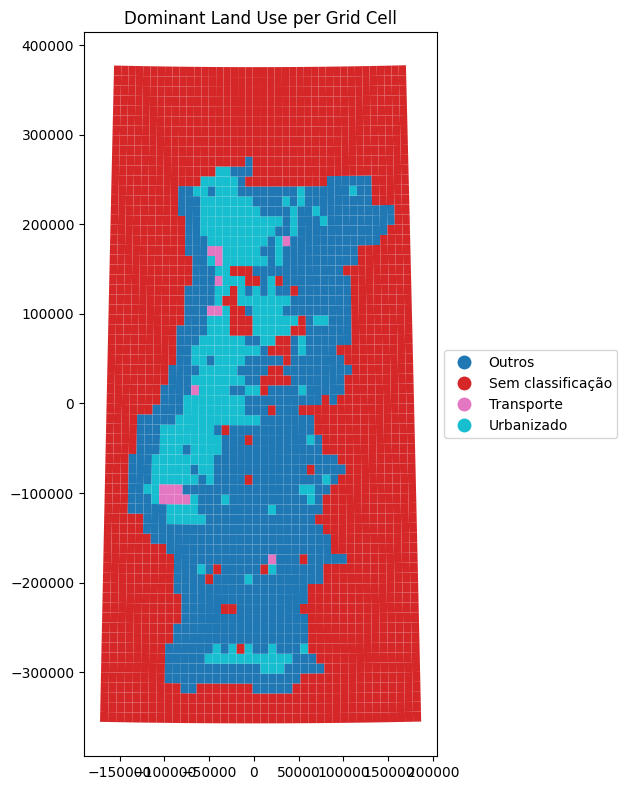

In [193]:
fig, ax = plt.subplots(figsize=(10, 8))

gdf_landuse.plot(
    column="final_class",
    legend=True,
    ax=ax,
    legend_kwds={
        "loc": "center left",
        "bbox_to_anchor": (1, 0.5)  # (x, y) position of legend outside plot
    }
)

ax.set_title("Dominant Land Use per Grid Cell")
plt.tight_layout()
plt.show()

In [194]:
print(gdf_landuse.head())
gdf_landuse2 = gdf_landuse.copy()
print(gdf_landuse2.shape)

                                            geometry       pm10   lat   lon  \
0  POLYGON ((-162890.019 -355684.449, -162680.605...  21.447265  36.5 -10.0   
1  POLYGON ((-153923.887 -355848.775, -153726.01 ...  21.246418  36.5  -9.9   
2  POLYGON ((-144957.894 -356003.793, -144771.551...  21.712890  36.5  -9.8   
3  POLYGON ((-135992.032 -356149.504, -135817.222...  23.103515  36.5  -9.7   
4  POLYGON ((-127026.293 -356285.91, -126863.014 ...  24.775390  36.5  -9.6   

   cell_id     cell_area dominant_class  transporte_pct  urbanizado_pct  \
0        0  9.948622e+07            NaN             0.0             0.0   
1        1  9.947907e+07            NaN             0.0             0.0   
2        2  9.947232e+07            NaN             0.0             0.0   
3        3  9.946596e+07            NaN             0.0             0.0   
4        4  9.946000e+07            NaN             0.0             0.0   

   no_class_pct        final_class  
0         100.0  Sem classificação  


In [195]:
print(gdf_landuse2["final_class"].unique())

['Sem classificação' 'Outros' 'Urbanizado' 'Transporte']


In [196]:
landuse = gdf_landuse2[gdf_landuse2["final_class"] != "Sem classificação"]
print(landuse["final_class"].unique())
print(landuse.shape)

['Outros' 'Urbanizado' 'Transporte']
(1089, 11)


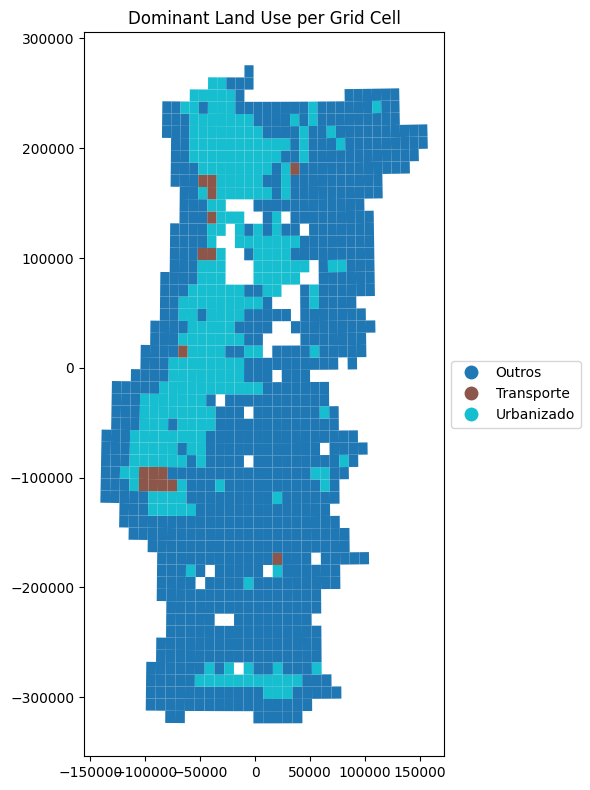

In [197]:
fig, ax = plt.subplots(figsize=(10, 8))

landuse.plot(
    column="final_class",
    legend=True,
    ax=ax,
    legend_kwds={
        "loc": "center left",
        "bbox_to_anchor": (1, 0.5)  # (x, y) position of legend outside plot
    }
)

ax.set_title("Dominant Land Use per Grid Cell")
plt.tight_layout()
plt.show()

In [198]:
dummies = pd.get_dummies(landuse['final_class'])

landuse['Urbanizado'] = dummies.get('Urbanizado', pd.Series(0, index=landuse.index)).astype(int)
landuse['Transporte'] = dummies.get('Transporte', pd.Series(0, index=landuse.index)).astype(int)
print(landuse.head())

                                              geometry       pm10   lat  lon  \
130  POLYGON ((-72950.963 -323616.954, -72856.176 -...  35.077472  36.8 -9.0   
131  POLYGON ((-64020.51 -323688.478, -63937.328 -3...  35.598631  36.8 -8.9   
139  POLYGON ((7421.761 -323924.903, 7412.119 -3128...  33.850259  36.8 -8.1   
140  POLYGON ((16351.992 -323912.49, 16330.747 -312...  33.103840  36.8 -8.0   
141  POLYGON ((25282.237 -323890.751, 25249.39 -312...  32.626301  36.8 -7.9   

     cell_id     cell_area dominant_class  transporte_pct  urbanizado_pct  \
130      130  9.905241e+07         Outros             0.0             0.0   
131      131  9.904924e+07         Outros             0.0             0.0   
139      139  9.903783e+07         Outros             0.0             0.0   
140      140  9.903816e+07         Outros             0.0             0.0   
141      141  9.903887e+07         Outros             0.0             0.0   

     no_class_pct final_class  Urbanizado  Transporte  


c:\Users\franc\Desktop\ProjIntegrador\.venv\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\franc\Desktop\ProjIntegrador\.venv\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [199]:
landuse.to_file("landuse.gpkg", driver="GPKG")